In [1]:
from textblob import TextBlob
import csv
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# sentiment analysis
tweets1 = pd.read_csv("data/tweets_china_022122.csv")
tweets1.columns = ["Date","id1","id2","popularity","content"]
tweets2 = pd.read_csv('data/tweets_china_021822.csv')
tweets2.columns = ["Date","id1","id2","popularity","content"]
tweets3 = pd.read_csv('data/tweets_china_021422.csv')
tweets3.columns = ["Date","id1","id2","popularity","content"]
tweets = pd.concat([tweets1, tweets2, tweets3], axis = 0)
tweets = tweets.drop_duplicates()

sent = []
sub = []
for tweet in tweets.content:    
    blob = TextBlob(tweet)    
    sent.append(blob.sentiment[0])
    sub.append(blob.sentiment[1])

# add to tweets df
tweets['sentiment'] = pd.Series(sent)
tweets['subjectivity'] = pd.Series(sub)

# aggregate data by day
tweets['date'] = pd.to_datetime(tweets['Date'])
tweets['date'] = tweets['date'].dt.date

tweets1 = tweets.groupby('date').agg('mean')
# drop irrelevant cols
tweets1.drop(['id1', 'id2'], axis = 1, inplace = True)
tweets1.head()

,sentiment,subjectivity
date,,
2022-02-09,0.030314,0.339559
2022-02-10,0.036832,0.328886
2022-02-11,0.032370,0.349874
2022-02-12,0.024390,0.329135
2022-02-13,0.031844,0.337820


In [4]:
# read in sp500 data
# sp 500 data
sp = pd.read_csv('S&P 500 Historical Data.csv', header = 0, thousands=',')
sp['date'] = pd.to_datetime(sp['Date'])
sp['date'] = sp['date'].dt.date
sp.drop('Date', axis = 1, inplace = True)

# merge stock and tweet data
df = tweets1.merge(sp, how = "inner", on = "date")
# categorical dependent var
inc_dec = []
for i in df['Change %']:
    ch = float(i.strip('%'))/100
    if ch >= 0:
        inc_dec.append(1)
    elif ch < 0:
        inc_dec.append(-1)

df['change'] = pd.Series(inc_dec)

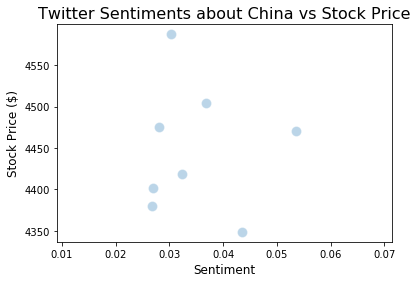

In [5]:
# summary plots?
plt.scatter(x = 'sentiment', y = 'Price', data = df, s = 100, alpha = 0.3, edgecolor = 'white')
plt.title('Twitter Sentiments about China vs Stock Price', fontsize = 16)
plt.ylabel('Stock Price ($)', fontsize = 12)
plt.xlabel('Sentiment', fontsize = 12)
plt.show()

In [7]:
#split train/test data
np.random.seed(5678)
train, test = train_test_split(df, test_size = 0.2, random_state = 42)


# build model
y_train = train.pop('Price')
x_train = train[['sentiment', 'subjectivity']]

Intercept:  3747.334587370061
Coefficients:  [-2245.69789221  2255.19747366]


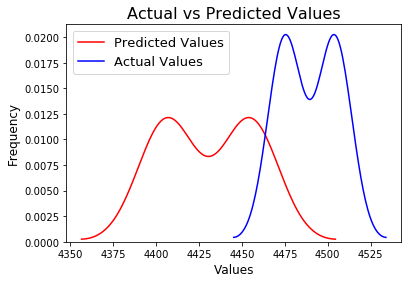

In [8]:
#sklearn
lr = LinearRegression()
lr.fit(x_train,y_train)
yhat = lr.predict(test[['sentiment', 'subjectivity']])
print('Intercept: ', lr.intercept_)
print('Coefficients: ', lr.coef_)
#print('R-Squared :', lr.score(test[['sentiment', 'subjectivity']], test['Price']))

sb.distplot(yhat, hist = False, color = 'r', label = 'Predicted Values')
sb.distplot(test['Price'], hist = False, color = 'b', label = 'Actual Values')
plt.title('Actual vs Predicted Values', fontsize = 16)
plt.xlabel('Values', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()
#plt.savefig('ap.png')


In [9]:
#statsmodels
x_var = df[['sentiment', 'subjectivity']]
y_var = df['Price']

sm_x_var = sm.add_constant(x_var)
mlr_model = sm.OLS(y_var, sm_x_var)
mlr_reg = mlr_model.fit()
print(mlr_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.393
Method:                 Least Squares   F-statistic:                   0.01296
Date:                Fri, 25 Feb 2022   Prob (F-statistic):              0.987
Time:                        13:07:38   Log-Likelihood:                -45.518
No. Observations:                   8   AIC:                             97.04
Df Residuals:                       5   BIC:                             97.27
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         4286.4985   1174.585      3.649   

/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [16]:
#split train/test data
train, test = train_test_split(df, test_size = 0.2, random_state = 42)

y_train = train.pop('change')
x_train = train[['sentiment', 'subjectivity']]
y_test = test.pop('change')
x_test = test[['sentiment', 'subjectivity']]

In [17]:
# knn
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(x_train, y_train) 
neigh.score(x_test, y_test)
neigh_cv = cross_val_score(neigh, x_train, y_train, cv=2) 
print(neigh_cv.mean()) 

0.6666666666666666


In [18]:
# logit
logreg = LogisticRegression(random_state=42)
logreg.fit(x_train, y_train)
logreg.score(x_test, y_test)
logreg_cv = cross_val_score(logreg, x_train, y_train, cv=2)
print(logreg_cv.mean())

0.6666666666666666


In [19]:
# svm
svm_linear = SVC( kernel = 'linear')
svm_linear.fit(x_train, y_train)
svm_linear.score(x_test, y_test)
svm_linear_cv = cross_val_score(svm_linear, x_train, y_train, cv=2)
print(svm_linear_cv.mean())

0.6666666666666666


In [20]:
# random forest
forest_reg = RandomForestClassifier(random_state=42)
forest_reg.fit(x_train, y_train)
forest_reg.score(x_test, y_test)
forest_reg_cv = cross_val_score(forest_reg, x_train, y_train, cv=2) 
print(forest_reg_cv.mean())  

0.16666666666666666
